## Dataset Information

In my **bone fracture detection system** project, I use [XR-bones Dataset for Bone Fracture Detection](https://www.kaggle.com/datasets/japeralrashid/xr-bones-dataset-for-bone-fracture-detection/data) dataset to train my deep neural network algorithm.

Overview
The XR-bones dataset is a comprehensive collection of X-ray images designed to facilitate research and development in bone fracture detection using computer vision techniques. This dataset contains X-ray images categorized into two main classes: negative (no fracture) and positive (fracture present). The data is further organized by specific anatomical regions, ensuring a diverse and detailed representation of bone fractures.

Classes 

The dataset is divided into the following categories:

| Negative Classes (No Fracture) | Positive Classes (Fracture Present) |
| ------------------------------ | ----------------------------------- |
| XR_ELBOW_negative              | XR_ELBOW_positive                   |
| XR_FINGER_negative             | XR_FINGER_positive                  |
| XR_FOREARM_negative            | XR_FOREARM_positive                 |
| XR_HAND_negative               | XR_HAND_positive                    |
| XR_SHOULDER_negative           | XR_SHOULDER_positive                |

But the distribution of above categories is imbalance, so I decide to combine the classes into two categories:

1. Negative Classes (No Fracture)
2. Positive Classes (Fracture Present)


Validation Data:

In addition to the main dataset, a validation set is provided to evaluate model performance. The validation set includes 100 images randomly selected from each class, along with their corresponding labels and bounding box annotations.

Validation Directories:
- validation_classes
- validation_labels

Data Description

Each txt file contains the following information for the respective images:

- Image ID: A unique identifier for each image.
- Class Label: Indicates whether the image is classified as negative (0) or positive (1).
- Bounding Box Coordinates: The coordinates (x_min, y_min, x_max, y_max) of the bounding box surrounding the fracture area.

Applications

The XR-bones dataset is ideal for developing and evaluating automated bone fracture detection algorithms. Potential applications include:

- Medical Diagnostics: Assisting radiologists in detecting fractures quickly and accurately.
- Research: Facilitating research in computer vision, deep learning, and medical image analysis.
- Education: Serving as a valuable resource for educational purposes in medical and technological fields.
Usage

To use this dataset, follow these steps:

1. Download the Dataset: Ensure you have sufficient storage space and a reliable internet connection.
2. Extract the Files: Unzip the downloaded files to access the images and CSV annotations.
3. Load the Data: Use appropriate data loading techniques to read the images and annotations into your machine learning pipeline.
4. Train and Evaluate Models: Utilize the dataset to train and evaluate bone fracture detection models using techniques such as Convolutional Neural Networks (CNNs) and other machine learning algorithms.

## Calculate distribution of labels

In th first part, I will count the distribution of labels, this contains the following step:

1. Collect all the paths for images containing no fracture and fracture.

2. Load all the labels that match the image in step 1, most names of image and label are same, I need to filter the unmatched file name.

In [1]:
import cv2
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# YOLODataSet
ROOT_DIR = 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet'
IMAGE_DIR = Path(ROOT_DIR).joinpath('images')
TRAIN_DIR = Path(IMAGE_DIR).joinpath('train')
VALID_DIR = Path(IMAGE_DIR).joinpath('val')

In [3]:
# YOLODataSet
image_paths = [imgPath for imgPath in TRAIN_DIR.glob('*.png')]

image_paths[:5]

[WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_10.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_100.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1000.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1001.png')]

In [4]:
ex_path = random.choice(image_paths)
ex_label_path = str(ex_path).replace('images', 'labels').replace('.png', '.txt')
print(ex_label_path)

with open(ex_label_path, 'r') as file:
    lines = file.readlines()  # Read all lines from the file

for line in lines:
    print(line.strip().split())

C:\Users\User\Desktop\Data_Science_Notebook\projects\project__bone_fracture_detection\YOLODataSet\labels\train\XR_FINGER_negative_2362.txt
['6', '0.000000', '0.000000', '0.000000', '0.000000']


In [5]:
def load_label_info(label_path: str) -> tuple:
    """
    Load label data from a file and convert it into a list of rectangles with their labels.

    Args:
        label_path (str): The path to the label file.

    Returns:
        tuple: 
            - str: Overall label type ("negative" or "positive").
            - list: A list of tuples, where each tuple contains:
                - label (str): The label of the rectangle.
                - coordinates (tuple): A tuple (x_center, y_center, width, height) representing
                  the bounding box of the rectangle.
    """
    rectangles = []  # List to store rectangles with their positions
    overall_label = 0 # Default is "negative"

    with open(label_path, 'r') as file:
        lines = file.readlines()  # Read all lines from the file
        for line in lines:
            # Parse the line into a list of float values
            info = line.strip().split()

            # The remaining values are coordinate information
            x_center, y_center, width, height = map(float, info[1:])
            
            # Check if the values indicate a negative label
            if not (x_center == 0.0 and y_center == 0.0 and width == 0.0 and height == 0.0):
                overall_label = 1  # Set overall label to "positive"
            
            # Append the label and bounding box to the rectangles list
            rectangles.append((overall_label, (x_center, y_center, width, height)))

    return (overall_label, rectangles)  # Return the overall label and list of labeled rectangles



In [6]:
# Sample one image to check
rand_img_path = random.choice(image_paths)
rand_label_path = str(rand_img_path).replace('images', 'labels').replace('.png', '.txt')
load_label_info(rand_label_path)

(0, [(0, (0.0, 0.0, 0.0, 0.0))])

In [7]:
# Collect all the images and labels
images = []
labels = []
for image_path in image_paths:
    label_path = str(image_path).replace('images', 'labels').replace('.png', '.txt')
    try:
        label, rectangle = load_label_info(label_path)
        images.append((image_path, rectangle))
        labels.append(label)
    except: continue

len(images), len(labels)

(20501, 20501)

In [8]:
images[:5]

[(WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1.png'),
  [(0, (0.0, 0.0, 0.0, 0.0))]),
 (WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_10.png'),
  [(0, (0.0, 0.0, 0.0, 0.0))]),
 (WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_100.png'),
  [(0, (0.0, 0.0, 0.0, 0.0))]),
 (WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1000.png'),
  [(0, (0.0, 0.0, 0.0, 0.0))]),
 (WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1001.png'),
  [(0, (0.0, 0.0, 0.0, 0.0))])]

In [9]:
labels[:5]

[0, 0, 0, 0, 0]

## Images Visualization

After loading all the images and labels I have to calculate the distribution of labels and visualize the images that contain no fracture and fracture. 

In [10]:
dataset = {}

for label in labels:
    if label not in dataset:
        dataset[label] = 0
    dataset[label] += 1

dataset

{0: 14589, 1: 5912}

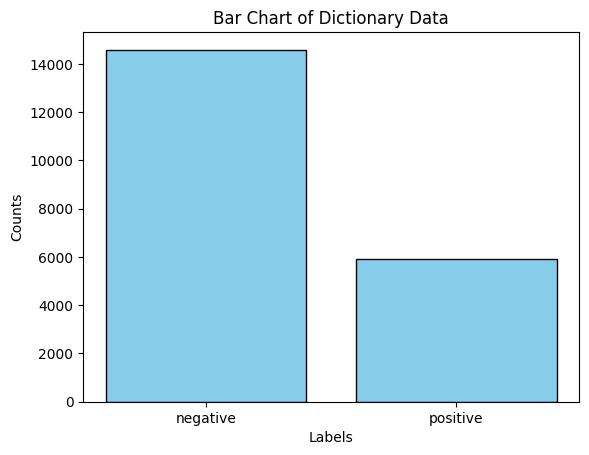

In [11]:
# Extract keys and values
keys = []
values = []
class_names = ['negative', 'positive']

for key, value in dataset.items():
    keys.append(class_names[int(key)])
    values.append(value)

# Create the bar chart
plt.bar(keys, values, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(keys)
plt.title('Bar Chart of Dictionary Data')

# Display the chart
plt.show()

In [12]:
def calculate_bounding_box(img_width: int, img_height: int, x_center: float, y_center: float, width: float, height: float):
    """
    Convert normalized bounding box coordinates to pixel coordinates.

    Args:
        img_width (int): The width of the image in pixels.
        img_height (int): The height of the image in pixels.
        x_center (float): The normalized x-coordinate of the box center (0 to 1).
        y_center (float): The normalized y-coordinate of the box center (0 to 1).
        width (float): The normalized width of the box (0 to 1).
        height (float): The normalized height of the box (0 to 1).

    Returns:
        tuple: Bounding box pixel coordinates as (x_min, y_min, x_max, y_max).
    """
    x_center_px = int(x_center * img_width)
    y_center_px = int(y_center * img_height)
    box_width_px = int(width * img_width)
    box_height_px = int(height * img_height)

    x_min = x_center_px - box_width_px // 2
    y_min = y_center_px - box_height_px // 2
    x_max = x_center_px + box_width_px // 2
    y_max = y_center_px + box_height_px // 2

    return x_min, y_min, x_max, y_max


def plot_multiple_images_with_rectangles(images_selected:list, 
                                         class_names:list=['negative', 'positive'], 
                                         figsize:tuple=(15, 15), 
                                         fig_title:str='Medical Image Analysis For Fracture Detection'):
    """
    Plot multiple images with their rectangle annotations in a grid using matplotlib.
    
    Args:
        images_selected (list): A list of tuples, where each tuple contains:
            - imgPath (str): The file path to the image.
            - rectangles (list): A list of bounding box data, where each bounding box is a tuple:
                (class_id, (x_center, y_center, width, height)), where:
                - class_id (int): The class index of the bounding box.
                - x_center (float): The normalized x-coordinate of the bounding box center (0 to 1).
                - y_center (float): The normalized y-coordinate of the bounding box center (0 to 1).
                - width (float): The normalized width of the bounding box (0 to 1).
                - height (float): The normalized height of the bounding box (0 to 1).
        class_names (list, optional): A list of class names corresponding to the `class_id` values in the rectangles.
                                      Defaults to ['negative', 'positive'].
        figsize (tuple, optional): The size of the overall figure in inches. Defaults to (15, 15).
        fig_title (str, optional): The overall title for the entire figure. Defaults to 'Medical Image Analysis For Fracture Detection'.
    """
    # Calculate the side length of the grid (assume the number of images is a perfect square)
    side = np.sqrt(len(images_selected)).astype(np.int32)

    # Create a grid of subplots
    fig, axes = plt.subplots(side, side, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for idx, (imgPath, rectangles) in enumerate(images_selected):
        # Read the image using OpenCV
        image = cv2.imread(imgPath)
        if image is None:
            raise ValueError(f"Image not found at path: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for matplotlib
        img_height, img_width, _ = image.shape  # Get image dimensions

        # Class title
        class_title = ''

        # Draw each rectangle and its label on the image
        for class_id, (x_center, y_center, width, height) in rectangles:
            # Ensure class_id is an integer
            class_id = int(class_id)

            # Convert bounding box to pixel coordinates
            x_min, y_min, x_max, y_max = calculate_bounding_box(img_width, img_height, x_center, y_center, width, height)

            # Draw the bounding box and center point
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)  # Blue box

            # Add class label text
            class_title = class_names[class_id]
            cv2.putText(image, class_title, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        fontScale=0.5, color=(255, 255, 255), thickness=1)
        
        # Plot the image in the current subplot
        ax = axes[idx]
        ax.imshow(image)
        ax.axis('off')  # Turn off axes for a cleaner visualization
        
        # Add a title for the subplot
        ax.set_title(f"Image {idx + 1}: {'Health' if class_title == 'negative' else 'fracture'}")

    # Hide any unused axes (in case the number of images is less than the grid size)
    for ax in axes[len(images_selected):]:
        ax.axis('off')

    # Add an overall title for the figure
    fig.suptitle(fig_title, fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout for better spacing and show the figure
    # A rectangle in normalized figure coordinates into which the whole subplots area (including labels) will fit
    # left, bottom, right, top
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

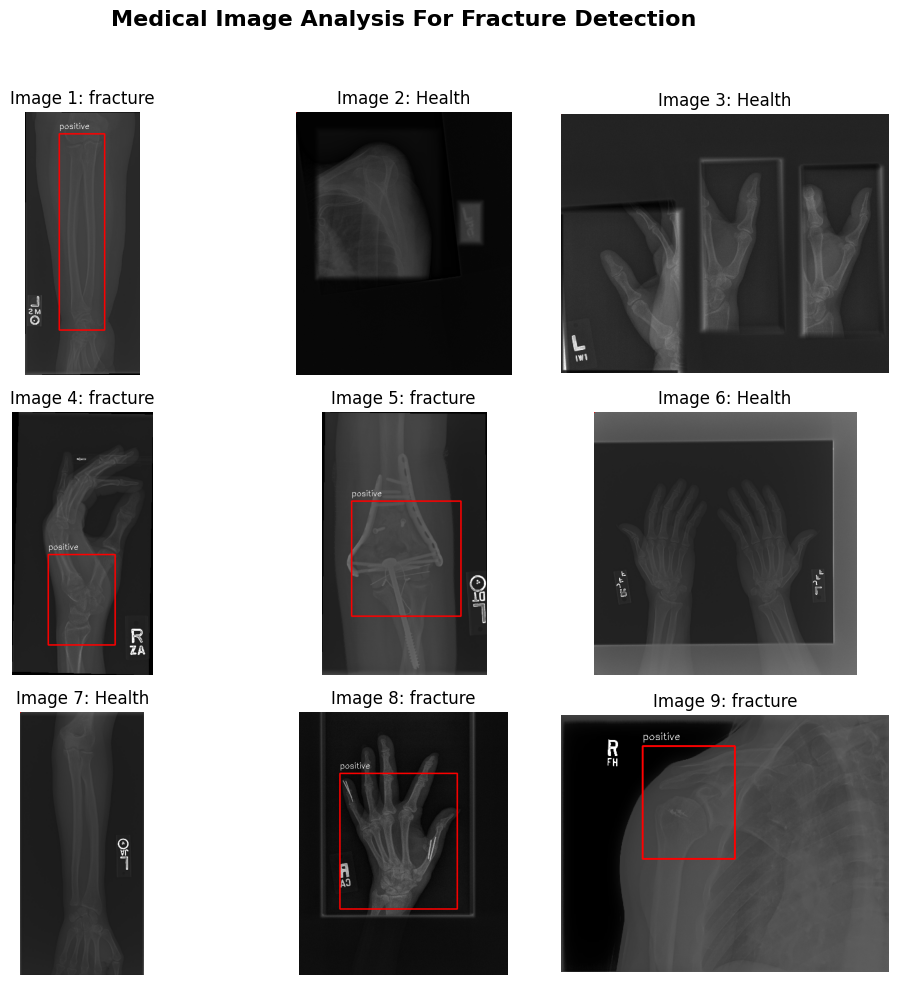

In [13]:
images_selected = random.choices(images, k=9)
plot_multiple_images_with_rectangles(images_selected, figsize=(10, 10))

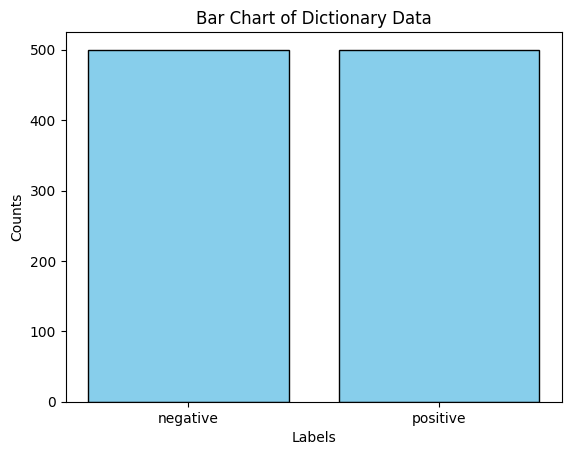

In [14]:
# Check the distribution of validation images
valid_image_paths = [imgPath for imgPath in VALID_DIR.glob('*.png')]

valid_images = []
valid_labels = []
for image_path in valid_image_paths:
    label_path = str(image_path).replace('images', 'labels').replace('.png', '.txt')
    try:
        label, rectangle = load_label_info(label_path)
        valid_images.append((image_path, rectangle))
        valid_labels.append(label)
    except: continue

if len(valid_images)==len(valid_labels):
    valid_dataset = {}
    for val_label in valid_labels:
        if val_label not in valid_dataset:
            valid_dataset[val_label] = 0
        valid_dataset[val_label] += 1

    # Extract keys and values
    valid_keys = []
    valid_values = []
    class_names = ['negative', 'positive']

    for key, value in valid_dataset.items():
        valid_keys.append(class_names[int(key)])
        valid_values.append(value)

    # Create the bar chart
    plt.bar(valid_keys, valid_values, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.xticks(valid_keys)
    plt.title('Bar Chart of Dictionary Data')

    # Display the chart
    plt.show()

### Observation

It seems the training dataset is imbalanced:

| Negative Counts | Positive Counts |
| --------------- | --------------- |
| 14589           | 5912            |

From my observation, the training dataset is imbalanced, with significantly more negative samples (14,589) than positive samples (5,912). This imbalance could cause the model to be biased toward predicting the majority class (negative), which could lead to poor performance in identifying the minority class (positive).

To address this issue, several strategies can be employed:

1. **Resampling Techniques**:
   - **Oversampling**: Increase the number of positive samples by duplicating or generating synthetic data. One popular technique for this is the **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm, which generates synthetic samples by interpolating between existing positive samples.
   - **Undersampling**: Reduce the number of negative samples to match the number of positive samples. While this helps balance the dataset, it may lead to the loss of important information.

2. **Class Weighting**: Many machine learning algorithms, including those in **TensorFlow** and **Scikit-learn**, offer class weights to penalize the model more for incorrect predictions on the minority class. This can be achieved by specifying higher weights for the positive class during model training. This encourages the model to pay more attention to the minority class.

3. **Data Augmentation**: Augmenting the dataset by applying transformations (such as rotations, flips, cropping, etc.) to the positive samples can help generate additional diverse examples, especially if the positive class has fewer variations in features compared to the negative class.

4. **Evaluation Metrics**: In an imbalanced dataset, **accuracy** may not be the best evaluation metric. It's important to monitor metrics like **Precision**, **Recall**, **F1-score**, and **AUC-ROC** to get a better understanding of the model's performance across both classes. In my project, I am working with **imbalanced data** in **object detection** tasks, designing appropriate evaluation metrics becomes crucial to ensure the model's performance on both the majority and minority classes is fairly assessed. Hence I have several options to be considered:
   - **Precision**: Measures how many of the predicted positive bounding boxes are correct. It is the ratio of true positives (TP) to all predicted positives (TP + false positives (FP)).【**Precision = TP / (TP + FP)**】
   - **Recall**: Measures how many of the actual positive bounding boxes were detected. It is the ratio of true positives (TP) to all actual positives (TP + false negatives (FN)).【**Recall = TP / (TP + FN)**】
   - **F1-Score**: This metric is particularly helpful because it penalizes a model that is biased toward one of the metrics (e.g., accuracy or recall), which is common when dealing with imbalanced data.【**F1-score = 2 * (Precision * Recall) / (Precision + Recall)**】
   - **Intersection over Union (IoU)**: **IoU** measures the overlap between the predicted bounding box and the ground truth bounding box. This is essential in object detection tasks to evaluate how accurate the bounding box predictions are. For imbalanced datasets, focusing on a reasonable IoU threshold is important.【**IoU = Area of Overlap / Area of Union**】
   - **Average Precision (AP) and Mean Average Precision (mAP)**: **Average Precision (AP)** is an evaluation metric that considers both precision and recall, and it is computed for each class by plotting the precision-recall curve 【**AP = ∫ (Precision * Recall) d(Recall)**】. **mAP** is the mean of the AP scores across all classes.
   - **Weighted Average Precision (WAP)**: To address class imbalance more effectively, one of all the options is **weighted average precision**, where the AP score for each class is weighted based on the class frequency or importance. This helps in giving more importance to the minority classes that may otherwise be overshadowed by the majority class.【**WAP = Σ (AP_class * class_weight) / total_weight**】

By implementing one or more of these methods, I can ensure that the model performs better on both the negative and positive classes, reducing bias toward the majority class and improving overall classification performance. 